# SherLock

## Load Libraries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle

## Load Data

This will cycle through all the data found in the Kaggle subset data, 'archive'.

### Functions Used

In [2]:
# Functions
def editTextFile(f):
    # Read in the file
    with open(f, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('[msec],size', '[msec];size')

    # Write the file out again
    with open('editTextFile.txt', 'w') as file:
        file.write(filedata)
        
def magVector(df,col1,col2,col3):
    # Calculate magnitude of vector - SQRT(X^2 + Y^2 + Z^2)
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))        

### Loading

In [3]:
# Non-standard columns present, need function to fix
#filename = './archive/AllBroadcasts.csv'
#AllBroadcasts = pd.read_csv(filename)
#AllBroadcasts['UUID'] = AllBroadcasts['UUID'].apply(pd.to_datetime, unit='ms')

# Drop bad rows for now...
#alphabet_string = string.ascii_lowercase
#alphabet_list = list(alphabet_string)

#AllBroadcasts[AllBroadcasts['timestamp'].str().isin(alphabet_list)]

#indexID = AllBroadcasts[(AllBroadcasts['timestamp'] >= 21)].index
#AllBroadcasts.drop(indexID, inplace = True)


#AllBroadcasts.head(3)

In [4]:
filename = './archive/AppPackages.csv'
AppPackages = pd.read_csv(filename)    # Ending columns need to be appended into sherlock_version - make function!

AppPackages[['UUID','InstallTime']] = AppPackages[['UUID', 'InstallTime']].apply(pd.to_datetime, unit='ms')
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 13'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 14'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 15'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 16'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 17'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 18'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 19'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 20'],sep=",")
#AppPackages.drop([])
#AppPackages = AppPackages.set_index('UUID')
print(AppPackages['UserId'].unique())
AppPackages = AppPackages.drop(columns=['UserId'])
print(AppPackages.shape)
AppPackages.head(1)

['97bb95f55a']
(298, 20)


,UUID,Action,AppPackage,AppUID,App_Name,InstallSrc,InstallTime,PackageHASH,Permissions,versionName,versionCode,sherlock_version,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,2016-04-27 23:33:20,Changed,com.google.android.gms,10012.0,Google Play services,com.android.vending,2014-12-18 10:53:20,c5762e46cb3b6c1585a8cdf95e2516ee473a5a7b,[android.permission.GET_ACCOUNTS,android.permission.INTERNET,android.permission.USE_CREDENTIALS,android.permission.SYSTEM_ALERT_WINDOW,android.permission.RECEIVE_BOOT_COMPLETED,com.google.android.providers.gsf.permission.RE...,android.permission.O,8.7.03 (2645110-238),8703238,2.2,NaN,NaN


In [5]:
filename = './archive/Bluetooth.csv'
Bluetooth = pd.read_csv(filename, parse_dates=['Bluetooth_timestamp'])
Bluetooth = Bluetooth.rename(columns={"UserID": "UUID", "UUID": "UserID"})   # Header names swapped apparently
Bluetooth['UUID'] = Bluetooth['UUID'].apply(pd.to_datetime, unit='ms')
#Bluetooth = Bluetooth.set_index('UUID')
print(Bluetooth['UserID'].unique())
Bluetooth = Bluetooth.drop(columns=['UserID'])
print(Bluetooth.shape)
Bluetooth.head(1)

['97bb95f55a']
(4398, 10)


,UUID,Bluetooth_appearance,Bluetooth_class,Bluetooth_mAddress,Bluetooth_mRemoteBrsf,Bluetooth_mValueNREC,Bluetooth_mValueWBS,Bluetooth_name,Bluetooth_rssi,Bluetooth_timestamp
0,2016-04-27 21:38:25.533,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-102,2016-04-28 00:38:25.529


In [6]:
filename = './archive/Calls.csv'
Calls = pd.read_csv(filename)
Calls[['UUID','Date']] = Calls[['UUID',
                                'Date']].apply(pd.to_datetime, unit='ms')
Calls['FromContacts'] = Calls['FromContacts'].astype(int)                      # Original True/False
#Calls = Calls.set_index('UUID')
print(Calls['UserId'].unique())
Calls = Calls.drop(columns=['UserId'])
print(Calls.shape)
Calls.head(1)

['97bb95f55a']
(1748, 6)


,UUID,Address,Date,Duration,FromContacts,Type
0,2016-04-28 11:42:11.668,c68ad8910c1a649507984b227f2c298140cf593c,2016-04-28 10:54:32.706,562,1,2


In [7]:
filename = './archive/Moriarty.csv'
editTextFile(filename)
Moriarty = pd.read_csv('editTextFile.txt')
Moriarty['UUID'] = (pd.to_datetime(Moriarty['UUID'], unit='ms'))
#Moriarty = Moriarty.set_index('UUID')
print(Moriarty['UserId'].unique())
Moriarty = Moriarty.drop(columns=['UserId'])
print(Moriarty.shape)
Moriarty.head(1)

['97bb95f55a']
(186, 7)


,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,malicious,malicious,5.0,0


In [8]:
filename = './archive/ScreenOn.csv'
ScreenOn = pd.read_csv(filename, parse_dates=['Timestamp'])
ScreenOn['UUID'] = (pd.to_datetime(ScreenOn['UUID'], unit='ms'))
ScreenOn['ScreenOn'] = ScreenOn['ScreenOn'].astype(int)                    # Original True/False
#ScreenOn = ScreenOn.set_index('UUID')
print(ScreenOn['UserID'].unique())
ScreenOn = ScreenOn.drop(columns=['UserID'])
print(ScreenOn.shape)
ScreenOn.head(1)

['97bb95f55a']
(1929, 3)


,UUID,ScreenOn,Timestamp
0,2016-04-27 23:21:44.991,1,2016-04-28 02:21:44.991


In [9]:
filename = './archive/SMS.csv'
SMS = pd.read_csv(filename)
SMS[['UUID','Date']] = SMS[['UUID','Date']].apply(pd.to_datetime, unit='ms')
SMS[['ContainsURL', 'FromContacts']] = SMS[['ContainsURL', 
                                            'FromContacts']].astype(int)   # Original True/False
#SMS = SMS.set_index('UUID')
print(SMS['UserId'].unique())
SMS = SMS.drop(columns=['UserId'])
print(SMS.shape)
SMS.head(1)

['97bb95f55a']
(605, 6)


,UUID,Address,ContainsURL,Date,FromContacts,Type
0,2016-05-02 09:20:06.299,db61c51fb5a33d6e9e9cfb0bd06cfc6fc355aee9,0,2016-05-02 09:01:43.741,1,2


In [10]:
filename = './archive/T0.csv'
T0 = pd.read_csv(filename, parse_dates=['Telephoney_timestemp', 
                                        'SystemInfo_timestemp'])
T0['UUID'] = (pd.to_datetime(T0['UUID'], unit='ms'))
#T0 = T0.set_index('UUID')
print(T0['UserId'].unique())
T0 = T0.drop(columns=['UserId'])
print(T0.shape)
T0.head(1)

['97bb95f55a']
(42, 28)


,UUID,Version,Telephoney_deviceId,Telephoney_deviceSoftwareVersion,Telephoney_networkCountryIso,Telephoney_networkOperator,Telephoney_networkOperatorName,Telephoney_networkType,Telephoney_phoneType,Telephoney_simCountryIso,...,Hardware_bluetoothMac,Hardware_androidId,Hardware_brand,Hardware_model,Hardware_deviceId,SystemInfo_OS_version,SystemInfo_Baseband_version,SystemInfo_SDK,SystemInfo_KernelInfo,SystemInfo_timestemp
0,2016-04-28 02:22:12.306,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,10,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-04-28 04:22:12.226


In [11]:
filename = './archive/T1.csv'
T1 = pd.read_csv(filename, parse_dates=['GooglePlayLoc_timestamp', 
                                        'CellTower_timestamp', 
                                        'Status_timestamp'])
T1['UUID'] = (pd.to_datetime(T1['UUID'], unit='ms'))
#T1 = T1.set_index('UUID')
print(T1['UserID'].unique())
T1 = T1.drop(columns=['UserID'])
print(T1.shape)
T1.head(1)

['97bb95f55a']
(24762, 35)


,UUID,Version,GooglePlayLoc_Speed,GooglePlayLoc_mAccuracy,5-means_geo,10-means_geo,25-means_geo,50-means_geo,75-means_geo,100-means_geo,...,Status_Brightness_settings,Status_DtmfVol,Status_MusicVol,Status_NotificationVol,Status_Orientation,Status_RingerMode,Status_RingtoneVol,Status_SystemVol,Status_VoiceCallVol,Status_timestamp
0,2016-04-27 21:33:18.919,2.2,0.0,25.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:33:06.062


In [12]:
filename = './archive/T2.csv'
T2 = pd.read_csv(filename, parse_dates=['TimeStemp'], low_memory=False)
T2['UUID'] = (pd.to_datetime(T2['UUID'], unit='ms'))
#T2 = T2.set_index('UUID')
print(T2['UserID'].unique())
T2 = T2.drop(columns=['UserID'])
print(T2.shape)
T2.head(1)

['97bb95f55a']
(78646, 244)


,UUID,Version,TimeStemp,AccelerometerStat_x_DC_FFT,AccelerometerStat_x_FIRST_IDX_FFT,AccelerometerStat_x_FIRST_VAL_FFT,AccelerometerStat_x_FOURTH_IDX_FFT,AccelerometerStat_x_FOURTH_VAL_FFT,AccelerometerStat_x_MEAN,AccelerometerStat_x_MEAN_FFT,...,AccelerometerStat_x_MIDDLE_SAMPLE,AccelerometerStat_y_MIDDLE_SAMPLE,AccelerometerStat_z_MIDDLE_SAMPLE,GyroscopeStat_x_MIDDLE_SAMPLE,GyroscopeStat_y_MIDDLE_SAMPLE,GyroscopeStat_z_MIDDLE_SAMPLE,MagneticField_x_MIDDLE_SAMPLE,MagneticField_y_MIDDLE_SAMPLE,MagneticField_z_MIDDLE_SAMPLE,pressure_MIDDLE_SAMPLE
0,2016-04-27 21:32:55.659,2.2,2016-04-28 00:32:55.659,112.709439,256.0,0.070102,254.0,0.079229,-0.557968,1.566997,...,-0.581192,1.294665,8.746617,-0.010386,-0.007457,-0.007191,-21.9,-9.06,-36.78,991.6177


In [13]:
filename = './archive/T3.csv'
T3 = pd.read_csv(filename, parse_dates=['Audio_timestemp', 
                                        'Light_timestamp'], low_memory=False)
T3['UUID'] = (pd.to_datetime(T3['UUID'], unit='ms'))
#T3 = T3.set_index('UUID')
print(T3['Userid'].unique())
T3 = T3.drop(columns=['Userid'])
print(T3.shape)
T3.head(1)

['97bb95f55a']
(144822, 26)


,UUID,version,Audio_diffSecs,Audio_l1Norm,Audio_l2Norm,Audio_linfNorm,AudPSD_AcrossFreqBands0,AudPSD_AcrossFreqBands1,AudPSD_AcrossFreqBands2,AudPSD_AcrossFreqBands3,...,Audio_mfccs6,Audio_mfccs7,Audio_mfccs8,Audio_mfccs9,Audio_mfccs10,Audio_mfccs11,Audio_timestemp,Light_accuracy,Light_lux,Light_timestamp
0,2016-04-27 21:33:00.114,2.2,1.076,8.83925,11.245488,7.28011,4.967447e+06,691379.249353,205718.34012,94940.81731,...,0.242247,1.056527,-0.279075,-0.080445,0.247651,0.293434,2016-04-28 00:33:00.108,3.0,5.0,2016-04-28 00:35:24


In [14]:
filename = './archive/T4.csv'
T4 = pd.read_csv(filename, parse_dates=['Traffic_timestamp', 
                                        'Battery_timestamp'], low_memory=False)
T4['UUID'] = (pd.to_datetime(T4['UUID'], unit='ms'))
T4['btime'] = (pd.to_datetime(T4['btime'], unit='s'))
#T4 = T4.set_index('UUID')
print(T4['Userid'].unique())
T4 = T4.drop(columns=['Userid'])
print(T4.shape)
T4.head(1)

['97bb95f55a']
(156017, 115)


,UUID,Version,CpuHertz,CPU_0,CPU_1,CPU_2,CPU_3,Total_CPU,TotalMemory_freeSize,TotalMemory_max_size,...,tot_iowait,tot_irq,tot_softirq,ctxt,btime,processes,procs_running,procs_blocked,connectedWifi_SSID,connectedWifi_Level
0,2016-05-09 11:26:40.348,2.3.1,1.7 GHz,45.833336,52.380955,80.0,61.904762,60.029762,8306960.0,536870912.0,...,594356.0,3118.0,1950319.0,1.331499e+09,2016-05-04 19:07:51,8384093.0,5.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0


In [15]:
filename = './archive/UserPresent.csv'
UserPresent = pd.read_csv(filename, parse_dates=['timestamp'])
UserPresent['UUID'] = (pd.to_datetime(UserPresent['UUID'], unit='ms'))
#UserPresent = UserPresent.set_index('UUID')
print(UserPresent['userID'].unique())
UserPresent = UserPresent.drop(columns=['userID'])
print(UserPresent.shape)
UserPresent.head(1)

['97bb95f55a']
(467, 2)


,UUID,timestamp
0,2016-04-27 23:21:49.555,2016-04-28 02:21:49.549


In [16]:
filename = './archive/Wifi.csv'
Wifi = pd.read_csv(filename)
Wifi['UUID'] = (pd.to_datetime(Wifi['UUID'], unit='ms'))
#Wifi = Wifi.set_index('UUID')
print(Wifi['UserID'].unique())
Wifi = Wifi.drop(columns=['UserID'])
print(Wifi.shape)
Wifi.head(1)

['97bb95f55a']
(110477, 5)


,UUID,SSID,Capabilities,Freq,Level
0,2016-04-27 21:33:18.919,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-78


## EDA

#### Moriarty exploration

In [17]:
print('Moriarty Sessions: ', Moriarty.SessionType.count())
#Moriarty.groupby('SessionType')['UUID'].nunique()
Moriarty.groupby('ActionType')['UUID'].nunique()

Moriarty Sessions:  186


ActionType
benign        43
malicious    143
Name: UUID, dtype: int64

In [18]:
Moriarty['SessionID'].value_counts()
#Moriarty['SessionID'].unique()
#Moriarty.groupby(['SessionID', 'SessionType']).count()

10    68
12    29
8     26
11    17
9     14
6     12
5     11
3      4
4      4
0      1
Name: SessionID, dtype: int64

In [19]:
pd.set_option('display.max_rows', None)
Moriarty

,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,malicious,malicious,5.0,0
1,2016-05-01 05:35:20.285,Login screen launched(login app);Skype,Shortcut Tapped,malicious,malicious,5.0,3
2,2016-05-01 05:35:20.288,App Entered onCreate(),App Mode Change,malicious,malicious,5.0,3
3,2016-05-01 05:35:20.378,App entered onResume(),App Mode Change,malicious,malicious,5.0,3
4,2016-05-01 05:35:39.256,Begin: Sending Password to server,Sending Data,malicious,malicious,5.0,3
5,2016-05-01 10:20:35.506,Login screen launched(login app);Facebook,Shortcut Tapped,malicious,malicious,5.0,4
6,2016-05-01 10:20:35.560,App Entered onCreate(),App Mode Change,malicious,malicious,5.0,4
7,2016-05-01 10:20:35.563,App entered onResume(),App Mode Change,malicious,malicious,5.0,4
8,2016-05-01 10:20:49.661,Begin: Sending Password to server,Sending Data,malicious,malicious,5.0,4
9,2016-05-01 12:25:10.549,App Entered onCreate(),App Mode Change,benign,malicious,5.0,5


In [20]:
pd.set_option('display.max_rows', 15)

Benign actions

In [21]:
Moriarty[Moriarty["ActionType"] == "benign"][["Details", "Action"]]

,Details,Action
9,App Entered onCreate(),App Mode Change
10,App entered onResume(),App Mode Change
20,App Entered onCreate(),App Mode Change
21,App entered onResume(),App Mode Change
22,App entered onPause(),App Mode Change
...,...,...
163,Entered to Game view,View Change
164,Entered to Game view,View Change
165,Entered to Game view,View Change
166,Entered to Game view,View Change


Malicious

In [22]:
Moriarty[Moriarty["ActionType"] == "malicious"][["Details", "Action"]]

,Details,Action
0,Added shortcut to the home screen(app);skype,Add Shortcut
1,Login screen launched(login app);Skype,Shortcut Tapped
2,App Entered onCreate(),App Mode Change
3,App entered onResume(),App Mode Change
4,Begin: Sending Password to server,Sending Data
...,...,...
181,App entered onPause(),App Mode Change
182,Successful send to server(duration [msec];size...,Sending Data
183,Begin: Sending Password to server,Sending Data
184,Successful send to server(duration [msec];size...,Sending Data


In [23]:
mSessList = Moriarty['SessionID'].unique()
minT = []
maxT = []

for i, ses in enumerate(mSessList):
    x = Moriarty[Moriarty['SessionID'] == ses]['UUID'].min()
    y = Moriarty[Moriarty['SessionID'] == ses]['UUID'].max()
    minT.append(x)
    maxT.append(y)

MoriartySessions = pd.concat([pd.Series(mSessList,name='SessionID'),
                              pd.Series(minT,name='minT'),
                              pd.Series(maxT,name='maxT')], axis=1)
MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
MoriartySessions

,SessionID,minT,maxT,Duration
0,0,2016-04-28 13:56:55.453,2016-04-28 13:56:55.453,0 days 00:00:00
1,3,2016-05-01 05:35:20.285,2016-05-01 05:35:39.256,0 days 00:00:18.971000
2,4,2016-05-01 10:20:35.506,2016-05-01 10:20:49.661,0 days 00:00:14.155000
3,5,2016-05-01 12:25:10.549,2016-05-03 19:20:29.641,2 days 06:55:19.092000
4,6,2016-05-03 19:20:46.068,2016-05-03 19:25:23.237,0 days 00:04:37.169000
5,8,2016-05-08 04:06:47.956,2016-05-08 05:50:28.485,0 days 01:43:40.529000
6,9,2016-05-11 22:33:16.789,2016-05-12 18:44:54.182,0 days 20:11:37.393000
7,10,2016-05-14 19:10:50.904,2016-05-17 10:14:09.707,2 days 15:03:18.803000
8,11,2016-05-17 17:57:43.255,2016-05-18 05:27:00.070,0 days 11:29:16.815000
9,12,2016-05-18 09:53:06.705,2016-05-18 09:59:56.193,0 days 00:06:49.488000


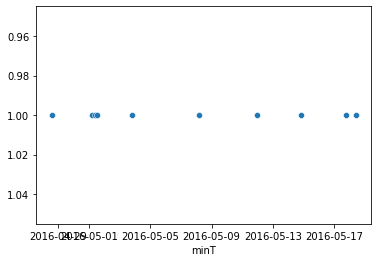

In [24]:
# time series plots of moriarty
sns.scatterplot(data=MoriartySessions, x='minT', y=1)
plt.gca().invert_yaxis()
plt.show()

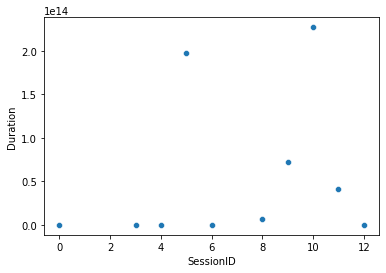

In [25]:
# duration of moriarty
sns.scatterplot(data=MoriartySessions, x='SessionID', y='Duration')
plt.gca().invert_yaxis()
plt.show()

In [26]:
# plot intra-session moriarty behavorior

## Feature engineering of Moriarty

In [27]:
binary = {'benign': 0, 'malicious': 1}
Moriarty = Moriarty.replace({'ActionType':binary})
Moriarty = Moriarty.replace({'SessionType':binary})
Moriarty

,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,1,1,5.0,0
1,2016-05-01 05:35:20.285,Login screen launched(login app);Skype,Shortcut Tapped,1,1,5.0,3
2,2016-05-01 05:35:20.288,App Entered onCreate(),App Mode Change,1,1,5.0,3
3,2016-05-01 05:35:20.378,App entered onResume(),App Mode Change,1,1,5.0,3
4,2016-05-01 05:35:39.256,Begin: Sending Password to server,Sending Data,1,1,5.0,3
...,...,...,...,...,...,...,...
181,2016-05-18 09:59:50.825,App entered onPause(),App Mode Change,1,1,5.0,12
182,2016-05-18 09:59:51.466,Successful send to server(duration [msec];size...,Sending Data,1,1,5.0,12
183,2016-05-18 09:59:51.784,Begin: Sending Password to server,Sending Data,1,1,5.0,12
184,2016-05-18 09:59:52.387,Successful send to server(duration [msec];size...,Sending Data,1,1,5.0,12


### Sensors

In [28]:
def magVector(df,col1,col2,col3):
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))
          
T2['magAccel'] = magVector(T2,'AccelerometerStat_x_MIDDLE_SAMPLE',
                           'AccelerometerStat_y_MIDDLE_SAMPLE',
                           'AccelerometerStat_z_MIDDLE_SAMPLE')
T2['magMag'] = magVector(T2,'MagneticField_x_MIDDLE_SAMPLE',
                           'MagneticField_y_MIDDLE_SAMPLE',
                           'MagneticField_z_MIDDLE_SAMPLE')
    
T2.head(3)

,UUID,Version,TimeStemp,AccelerometerStat_x_DC_FFT,AccelerometerStat_x_FIRST_IDX_FFT,AccelerometerStat_x_FIRST_VAL_FFT,AccelerometerStat_x_FOURTH_IDX_FFT,AccelerometerStat_x_FOURTH_VAL_FFT,AccelerometerStat_x_MEAN,AccelerometerStat_x_MEAN_FFT,...,AccelerometerStat_z_MIDDLE_SAMPLE,GyroscopeStat_x_MIDDLE_SAMPLE,GyroscopeStat_y_MIDDLE_SAMPLE,GyroscopeStat_z_MIDDLE_SAMPLE,MagneticField_x_MIDDLE_SAMPLE,MagneticField_y_MIDDLE_SAMPLE,MagneticField_z_MIDDLE_SAMPLE,pressure_MIDDLE_SAMPLE,magAccel,magMag
0,2016-04-27 21:32:55.659,2.2,2016-04-28 00:32:55.659,112.709439,256.0,0.070102,254.0,0.079229,-0.557968,1.566997,...,8.746617,-0.010386,-0.007457,-0.007191,-21.90,-9.06,-36.78,991.6177,8.860996,43.754565
1,2016-04-27 21:33:15.462,2.2,2016-04-28 00:33:15.462,14.500483,256.0,0.010774,232.0,0.168699,-0.074745,1.960746,...,8.868722,-0.011185,-0.008522,-0.007723,-22.74,-7.92,-37.86,991.6001,8.886932,44.868849
2,2016-04-27 21:33:35.793,2.2,2016-04-28 00:33:35.793,52.429426,256.0,0.021820,254.0,0.042375,-0.268869,0.786337,...,8.807071,-0.009854,-0.007723,-0.008256,-22.32,-9.54,-36.84,991.6167,8.872734,44.117792


In [29]:
# plots of sensors in time...

## Extract Moriarty across datasets

In [114]:
#Moriarty = Moriarty.set_index('UUID')
#ScreenOn = ScreenOn.set_index('UUID')

Merged = ScreenOn.append(Moriarty, sort=True)
#Merged = Merged.sort_index()
Merged = Merged.sort_values(by='UUID')

Merged['ScreenOn'] = Merged['ScreenOn'].fillna(method="pad")
pd.set_option('display.max_rows', None)
Merged

,Action,ActionType,Details,ScreenOn,SessionID,SessionType,Timestamp,UUID,Version
0,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:21:44.991,2016-04-27 23:21:44.991,NaN
1,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:22:50.982,2016-04-27 23:22:50.983,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:25:35.929,2016-04-27 23:25:35.929,NaN
3,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:25:47.083,2016-04-27 23:25:47.083,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:25:58.975,2016-04-27 23:25:58.976,NaN
5,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:26:08.903,2016-04-27 23:26:08.904,NaN
6,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 06:48:25.241,2016-04-28 03:48:25.242,NaN
7,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 06:48:44.582,2016-04-28 03:48:44.583,NaN
8,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 07:30:03.324,2016-04-28 04:30:03.324,NaN
9,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 07:31:09.900,2016-04-28 04:31:09.901,NaN


In [113]:
##### DAVE HELP #####



#mergedListNames = list(Merged)
#df = pd.DataFrame(columns = mergedListNames)
df = pd.DataFrame()

for index1, row1 in MoriartySessions.iterrows():
    #print(row['SessionID'],(Merged[((Merged['UUID'] > row['minT']) & (Merged['UUID'] < row['maxT']))]))
    #Merged[((Merged['UUID'] > row['minT']) & (Merged['UUID'] < row['maxT']))]
    #df[index] = Merged[((Merged['UUID'] > row['minT']) & (Merged['UUID'] < row['maxT']))]
    for index2, row2 in Merged.iterrows():
        #print(Merged.iloc[index2])
        #Merged.loc[((row2['UUID'] > row1['minT']) & (row2['UUID'] < row1['maxT']))]
        print([(row2['UUID'] > row1['minT']) & (row2['UUID'] < row1['maxT'])])
    
    
##### DAVE HELP #####

[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]

[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[Fal

[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


In [80]:
for i, row in Merged.iterrows():
    pass
    #ifor_val = something
    #if <condition>:
        #ifor_val = something_else
    #df.at[i,'ifor'] = ifor_val

In [32]:
x = Moriarty['UUID'][50]
print(x)
y = x + datetime.timedelta(seconds=3600)
AppPackages[((AppPackages['UUID'] > x) & (AppPackages['UUID'] < y))]

2016-05-08 05:23:02.006000


,UUID,Action,AppPackage,AppUID,App_Name,InstallSrc,InstallTime,PackageHASH,Permissions,versionName,versionCode,sherlock_version,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20


In [33]:
print(ScreenOn.shape)
ScreenOn.drop(ScreenOn[(ScreenOn['UUID'] > x) & (ScreenOn['UUID'] < (x + datetime.timedelta(seconds=0.0)))].index)

(1929, 3)


,UUID,ScreenOn,Timestamp
0,2016-04-27 23:21:44.991,1,2016-04-28 02:21:44.991
1,2016-04-27 23:22:50.983,0,2016-04-28 02:22:50.982
2,2016-04-27 23:25:35.929,1,2016-04-28 02:25:35.929
3,2016-04-27 23:25:47.083,0,2016-04-28 02:25:47.083
4,2016-04-27 23:25:58.976,1,2016-04-28 02:25:58.975
...,...,...,...
1924,2016-05-18 20:35:51.391,0,2016-05-18 23:35:51.390
1925,2016-05-18 21:35:42.868,1,2016-05-19 00:35:42.867
1926,2016-05-18 21:35:52.652,0,2016-05-19 00:35:52.652
1927,2016-05-18 21:36:06.226,1,2016-05-19 00:36:06.226


In [34]:
unit type action type
malicious vs benigin

SyntaxError: invalid syntax (<ipython-input-34-b6335c1ac500>, line 1)

In [ ]:
###### predict is screen on from magnitude

In [ ]:
#### predict screen on moriarty...

In [ ]:
sns.distplot(T2['AccelerometerStat_x_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_x_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

In [ ]:
sns.distplot(T2['AccelerometerStat_y_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_y_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

In [ ]:
sns.distplot(T2['AccelerometerStat_z_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_z_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

In [ ]:
sns.distplot(T2['pressure_MIDDLE_SAMPLE'])
plt.title('Histogram: pressure_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

### Goofy stuff

In [ ]:
t2_accelero = T2[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE',
                  'pressure_MIDDLE_SAMPLE']]

t2_accelero.isnull().values.any()
t2_accelero = t2_accelero.dropna()
t2_accelero.isnull().values.any()

t2_accelero_X = t2_accelero[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE']]
t2_accelero_y = t2_accelero[['pressure_MIDDLE_SAMPLE']]

X_train, X_test, y_train, y_test = train_test_split(t2_accelero_X, t2_accelero_y, random_state=42)

### Pipeline for pipeline assignment

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

Pretty poor, eh?  Well, what would you expect from a random grab...

### Pickle the model

In [ ]:
with open('model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Create faux-data

In [ ]:
print(X_test[0:2].values.tolist())

### Tests

In [ ]:
from newdata import newdata
newdata

In [ ]:
with open('model.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pipePKL = pickle.load(f)

In [ ]:
predictions = pipePKL.predict(newdata)
print(predictions)